In [ ]:
import sys
# sys.path.insert(0, '/home/ben.cline/code/jupitercvml_versions/20221117/JupiterCVML/europa/base/src/europa')

In [ ]:
import os

# from torchvision.transforms import ColorJitter, ToTensor, Compose
# from dl.augmentations.load_augmentations import TwoVarCompose, ColorJitter
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from dl.dataset.farm_field import DriveableTerrainDataset
from dl.config.label_map_helper import LabelMapHelper
from dl.utils.config import DEFAULT_NORMALIZATION_PARAMS, DEFAULT_WEIGHTED_SAMPLING_PARAMS
from dl.utils.helpers import seed_worker
from dl.utils.losses import get_losses

%matplotlib inline

In [ ]:
dataset = 'halo_rgb_stereo_train_v6_1'

In [ ]:
data_dir = f'/data2/jupiter/datasets/{dataset}/'
full = pd.read_csv(os.path.join(data_dir, 'master_annotations.csv'),nrows=1000)

In [ ]:
full[full.rectified_stereo_output_width == 640]

In [ ]:
# dataset_df = full[full.rectified_stereo_output_width == 640].head(1).sample(n=100, random_state=1, replace=True)
dataset_df = full[full.rectified_stereo_output_width == 640].sample(n=16, random_state=1, replace=True)


In [ ]:
from dl.dataset.datamodes.npz.rectifiedrgb import RectifiedRGBNPZ
import torch
batch_size = 8
batch_vals = []
labels = []
depth = []
b = 0
for i in range(batch_size):
    artifacts = RectifiedRGBNPZ(data_dir, run_productivity_metrics=False).get_artifacts(
        full.iloc[i + batch_size * b])
    batch_vals.append(np.concatenate([artifacts["image"]], 2))
    labels.append(artifacts["label"])
    depth.append(artifacts["depth"])
batch = torch.Tensor(np.stack(batch_vals)).permute(
    dims=[0, 3, 1, 2]
)#.to(device='cuda')
labels = torch.tensor(np.stack(labels))[:, None, :, :]#.to('cuda')
depth = torch.tensor(np.stack(depth)).permute(dims=[0, 3, 1, 2])#.to(device='cuda')
print(batch.shape)
print(batch[0,0,::100,::100])

In [ ]:
for i in range(2):
    arr = x[i].detach().numpy().transpose(1,2,0)
    plt.imshow(arr)
    plt.show()
    label = y[i][0].detach().numpy()
    label_to_plot = np.where(label == 255, -1, label)
    fig, ax = plt.subplots()
    plt.imshow(label_to_plot, vmin=-1, vmax=9, interpolation='nearest')
    plt.show()
    # plt.imshow(label == 255)
    # plt.colorbar()
    # plt.show()


In [ ]:
import onnx
import onnxruntime

from dl.utils.colors import classlabels_viz_cmap, classlabels_viz_norm


In [ ]:
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_1_10x_human_hundredth_trees_objects_rev1_full_512_640.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_50k_nextvit_small_sample_2_dynamic_quarter_res_512_640.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_50k_efficientvit_l1_512_quarter_res_dynamic.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_10x_human_hundredth_trees_objects_birds_as_birds_1000x_lower_humans_100x_vehicles_512_640_20240301.onnx'
onnx_path ='/mnt/sandbox1/alex.li/highres/bc_sandbox_2024/repvit_M1.5_512/bc_sandbox_2024_val_bestmodel.onnx'
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

In [ ]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
if len(ort_outs) == 2:
    ort_pred_labels = ort_outs[0]
    ort_confidences = ort_outs[1]
else:
    ort_pred_logits = ort_outs[0]
    ort_pred_labels = np.argmax(ort_pred_logits, axis=1)
ort_pred_labels.shape

In [ ]:
ort_pred_labels.min(), ort_pred_labels.max()

In [ ]:
x.shape

# TODO
# COMPARE TORCH AND ONNX RESULTS
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

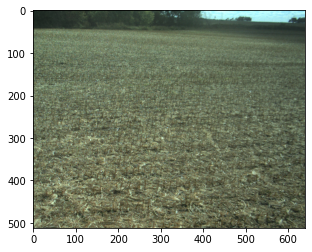

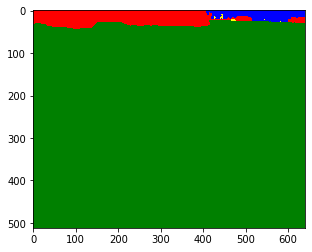

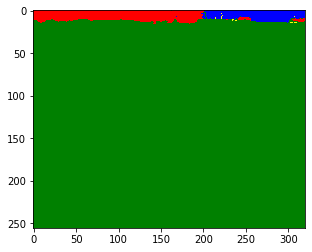

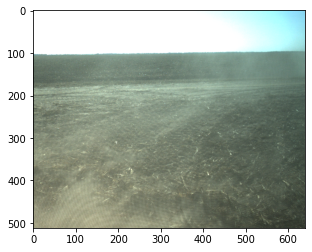

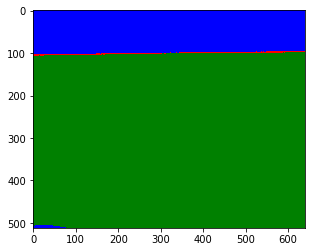

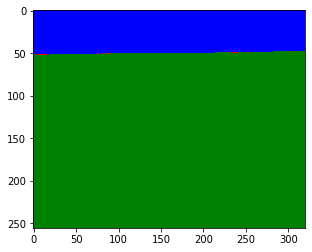

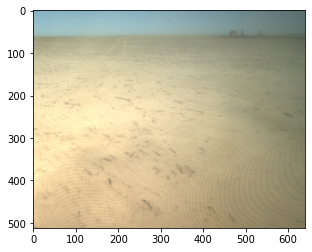

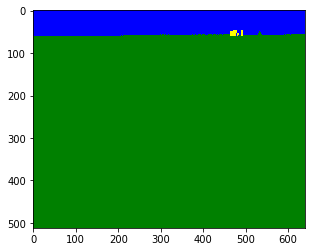

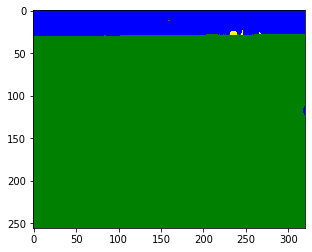

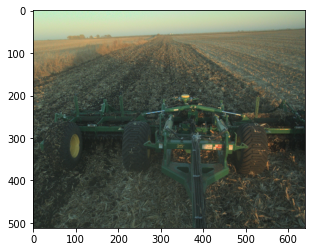

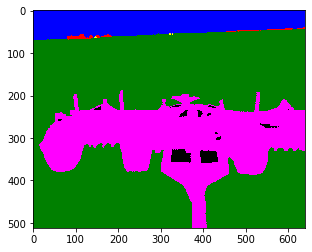

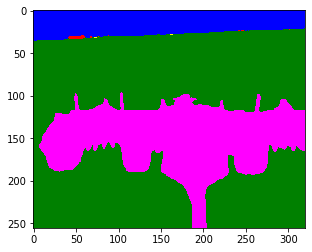

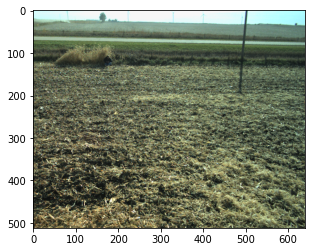

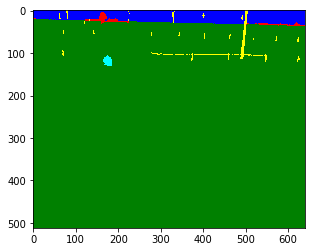

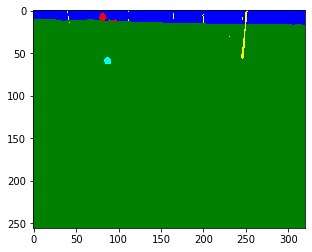

In [49]:
for i in range(5):
    arr = x[i].detach().numpy().transpose(1,2,0)
    plt.imshow(arr)
    plt.show()
    label = y[i][0].detach().numpy()    
    label_to_plot = np.where(label == 255, -1, label)
    fig, ax = plt.subplots()
    plt.imshow(label_to_plot, classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    plt.show()
    fig, ax = plt.subplots()
    # plt.imshow(ort_pred_labels[i][0], vmin=-1, vmax=9, interpolation='nearest')
    # plt.imshow(ort_pred_labels[i][0], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    plt.imshow(ort_pred_logits[i][0], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    
    

    # plt.imshow(ort_pred_labels[i], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')

    plt.show()
    # plt.imshow(label == 255)
    # plt.colorbar()
    # plt.show()